In [61]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score
import seaborn as sn
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, roc_curve, classification_report,\
                            accuracy_score, confusion_matrix, auc
from sklearn.ensemble import RandomForestClassifier
import shap
from xgboost import XGBClassifier

In [62]:
df = pd.read_csv('../../data/processed/data_model.csv')
df.shape

(1022, 9)

In [63]:
df

,QT_TOTAL_HIT_PAYWALL,DIASNAVEGADOS,NOTICIASLIDAS,VISITAS_CAPA,USOU_APP,PERFIL,PES_GENERO,ATR_PF_GEO_RENDA_FAM,IDADE
0,0,0,0,0,False,1,True,3,40.0
1,1,1,0,9,True,1,False,3,44.0
2,1,6,3,7,False,1,False,2,54.0
3,11,16,10,0,False,1,False,3,51.0
4,0,0,0,0,False,1,False,2,32.0
...,...,...,...,...,...,...,...,...,...
1017,0,2,2,1,False,0,True,4,34.0
1018,0,1,3,0,False,0,False,2,61.0
1019,0,6,3,0,False,0,True,3,25.0
1020,3,2,3,1,False,0,True,2,68.0


In [64]:
X = df.drop(['PERFIL'], axis=1)
y = df[['PERFIL']].astype(bool)

# Separando os dados em treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

# Sem nenhum balanceamento

In [65]:
model = XGBClassifier()
model.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[11:44:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Verificando a explicabilidade

In [66]:
explainer = shap.TreeExplainer(model)

In [67]:
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


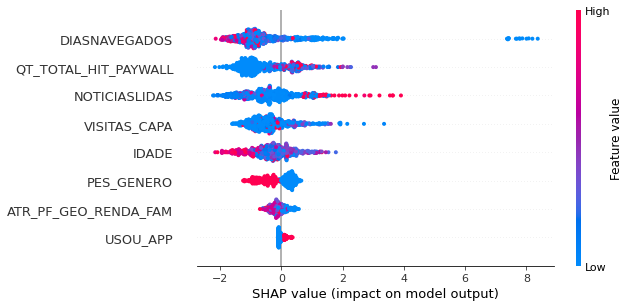

In [68]:
shap.summary_plot(shap_values, X_train, feature_names=X.columns)

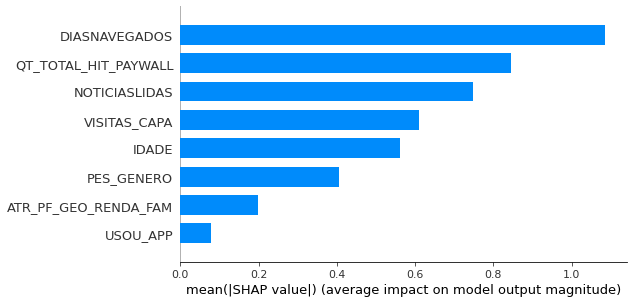

In [69]:
shap.summary_plot(shap_values, X_train, feature_names=X.columns, plot_type="bar")

In [70]:
# Avaliação do Modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('accuracy:', accuracy)
print('recall:  ', recall)
print('f1:      ', f1)

accuracy: 0.9585798816568047
recall:   0.3125
f1:       0.4166666666666667


In [71]:
# Criando um df com od dados de teste e o que foi predito
data = pd.DataFrame(data = y_test['PERFIL'])
data['Predict'] = y_pred
data = data.rename(columns = {'PERFIL': 'Actual'})

In [72]:
# Criando a Matrix de Confusão
df_matrix = pd.DataFrame(data, columns=['Actual','Predict'])
confusion_matrix = pd.crosstab(df_matrix['Actual'], df_matrix['Predict'], 
                               rownames = ['Actual'], colnames=['Predict'])

In [73]:
df_matrix

,Actual,Predict
672,False,False
154,False,False
743,False,False
776,False,False
454,False,False
...,...,...
592,False,False
103,False,False
86,False,False
180,False,False


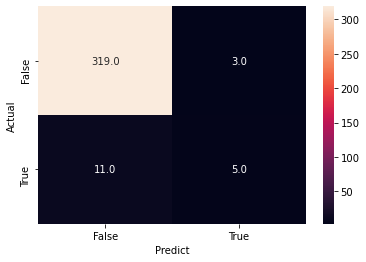

In [74]:
# Vizualizando a Matrix de confusão com o heatmap
sn.heatmap(confusion_matrix, annot = True, fmt=".1f")
plt.show()

In [75]:
# Predizendo as probabilidades 
yhat = model.predict_proba(X_test)

# Mantendo somente a classe positiva

yhat = yhat[:, 1]

In [76]:
# Plot da AUC
def plot_roc_curve(y_true, y_score, figsize=(10,6)):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize = figsize)
    auc_value = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, color = 'orange', label = 'ROC curve (area = %0.9f)' % auc_value)
    plt.plot([0, 1], [0, 1], color = 'darkblue', linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

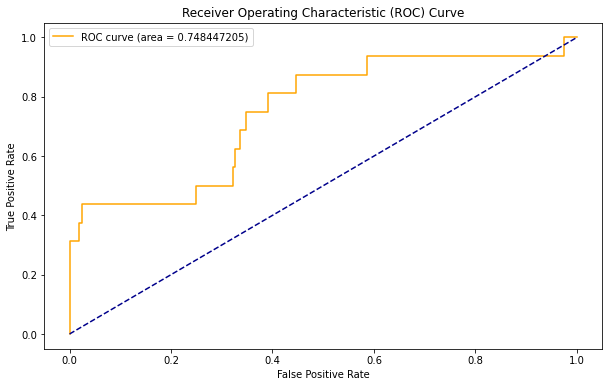

In [77]:
plot_roc_curve(y_test, yhat)

# Under Sample

In [78]:
# Under sampling para balanceamento do dataset

random_over_sampler = RandomUnderSampler()
X_res, y_res = random_over_sampler.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res)

In [79]:
model = XGBClassifier()
model.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[11:44:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Verificando a explicabilidade

In [80]:
explainer = shap.TreeExplainer(model)

In [81]:
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


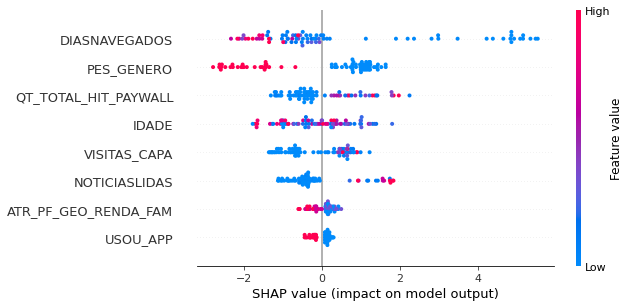

In [82]:
shap.summary_plot(shap_values, X_train, feature_names=X.columns)

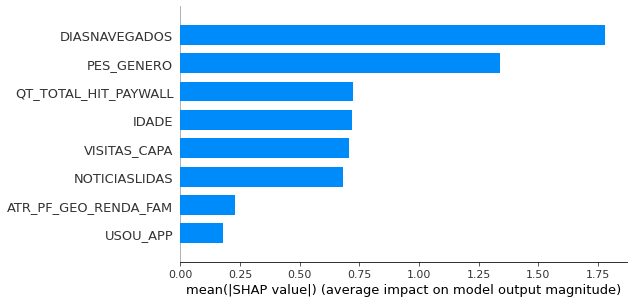

In [83]:
shap.summary_plot(shap_values, X_train, feature_names=X.columns, plot_type="bar")

In [84]:
# Avaliação do Modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('accuracy:', accuracy)
print('recall:  ', recall)
print('f1:      ', f1)

accuracy: 0.5769230769230769
recall:   0.6923076923076923
f1:       0.6206896551724138


In [85]:
# Criando um df com od dados de teste e o que foi predito
data = pd.DataFrame(data = y_test['PERFIL'])
data['Predict'] = y_pred
data = data.rename(columns = {'PERFIL': 'Actual'})

In [86]:
# Criando a Matrix de Confusão
df_matrix = pd.DataFrame(data, columns=['Actual','Predict'])
confusion_matrix = pd.crosstab(df_matrix['Actual'], df_matrix['Predict'], 
                               rownames = ['Actual'], colnames=['Predict'])

In [87]:
df_matrix

,Actual,Predict
51,False,False
61,True,True
38,False,True
60,True,True
37,False,False
14,False,True
31,False,False
19,False,False
15,False,True
90,True,True


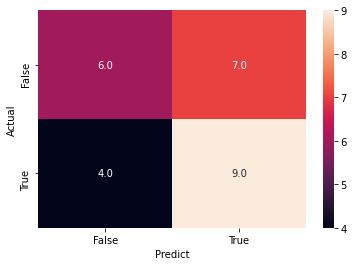

In [88]:
# Vizualizando a Matrix de confusão com o heatmap
sn.heatmap(confusion_matrix, annot = True, fmt=".1f")
plt.show()

In [89]:
# Predizendo as probabilidades 
yhat = model.predict_proba(X_test)

# Mantendo somente a classe positiva

yhat = yhat[:, 1]

In [90]:
# Plot da AUC
def plot_roc_curve(y_true, y_score, figsize=(10,6)):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize = figsize)
    auc_value = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, color = 'orange', label = 'ROC curve (area = %0.9f)' % auc_value)
    plt.plot([0, 1], [0, 1], color = 'darkblue', linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

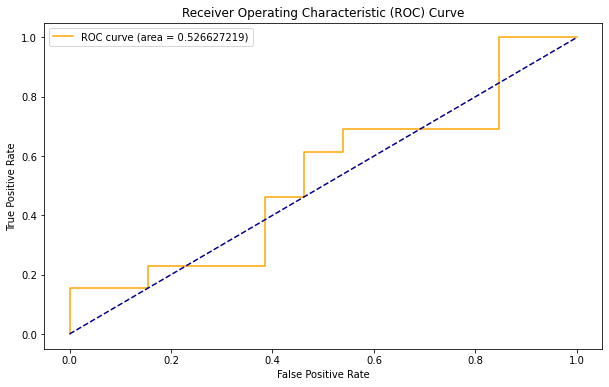

In [91]:
plot_roc_curve(y_test, yhat)

# Over Sample

In [92]:
# Over sampling para balanceamento do dataset

random_over_sampler = RandomOverSampler()
X_res, y_res = random_over_sampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res)

In [93]:
model = XGBClassifier()
model.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[11:44:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Verificando a explicabilidade

In [94]:
explainer = shap.TreeExplainer(model)

In [95]:
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


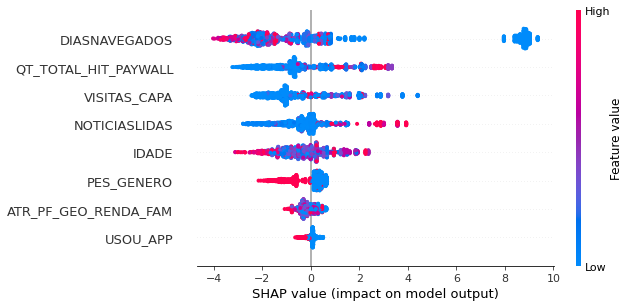

In [96]:
shap.summary_plot(shap_values, X_train, feature_names=X.columns)

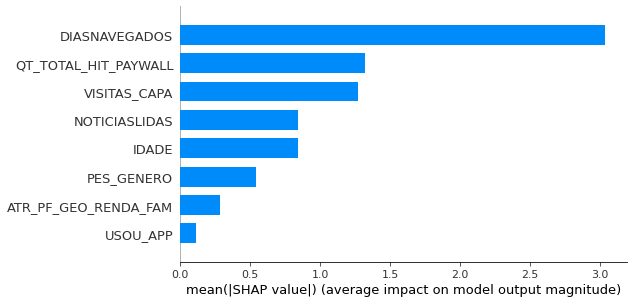

In [97]:
shap.summary_plot(shap_values, X_train, feature_names=X.columns, plot_type="bar")

In [98]:
# Avaliação do Modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('accuracy:', accuracy)
print('recall:  ', recall)
print('f1:      ', f1)

accuracy: 0.9917525773195877
recall:   1.0
f1:       0.9917012448132779


In [99]:
# Criando um df com od dados de teste e o que foi predito
data = pd.DataFrame(data = y_test['PERFIL'])
data['Predict'] = y_pred
data = data.rename(columns = {'PERFIL': 'Actual'})

In [100]:
# Criando a Matrix de Confusão
df_matrix = pd.DataFrame(data, columns=['Actual','Predict'])
confusion_matrix = pd.crosstab(df_matrix['Actual'], df_matrix['Predict'], 
                               rownames = ['Actual'], colnames=['Predict'])

In [101]:
df_matrix

,Actual,Predict
1078,True,True
1431,True,True
1485,True,True
674,False,False
1425,True,True
...,...,...
597,False,False
1729,True,True
393,False,False
1059,True,True


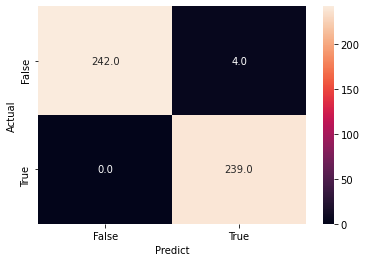

In [102]:
# Vizualizando a Matrix de confusão com o heatmap
sn.heatmap(confusion_matrix, annot = True, fmt=".1f")
plt.show()

In [103]:
# Predizendo as probabilidades 
yhat = model.predict_proba(X_test)

# Mantendo somente a classe positiva

yhat = yhat[:, 1]

In [104]:
# Plot da AUC
def plot_roc_curve(y_true, y_score, figsize=(10,6)):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize = figsize)
    auc_value = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, color = 'orange', label = 'ROC curve (area = %0.9f)' % auc_value)
    plt.plot([0, 1], [0, 1], color = 'darkblue', linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

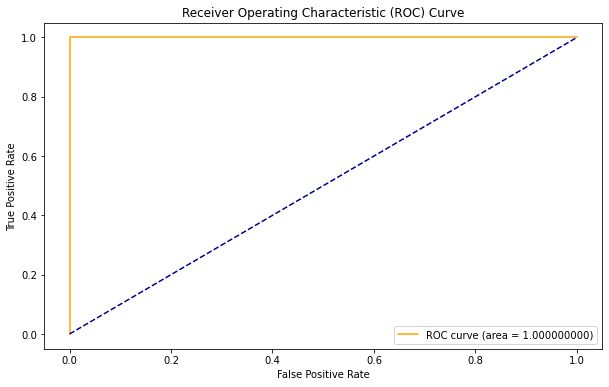

In [105]:
plot_roc_curve(y_test, yhat)

In [106]:
# Para o deploy 

In [107]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier()

## Verificando a explicabilidade

In [108]:
explainer = shap.TreeExplainer(model)

In [109]:
shap_values = explainer.shap_values(X_train)

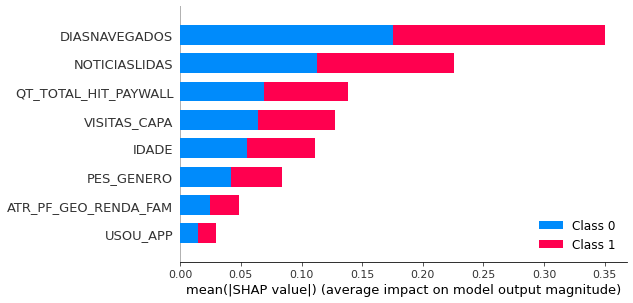

In [110]:
shap.summary_plot(shap_values, X_train, feature_names=X.columns)

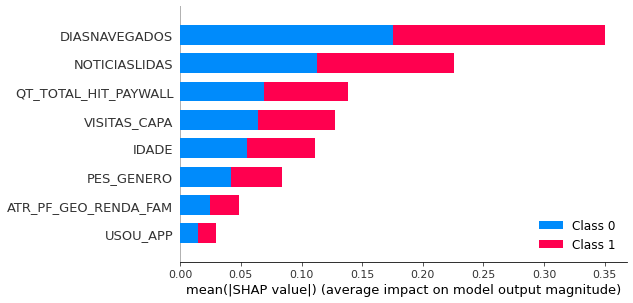

In [111]:
shap.summary_plot(shap_values, X_train, feature_names=X.columns, plot_type="bar")

In [112]:
# Avaliação do Modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('accuracy:', accuracy)
print('recall:  ', recall)
print('f1:      ', f1)

accuracy: 1.0
recall:   1.0
f1:       1.0


In [113]:
# Criando um df com od dados de teste e o que foi predito
data = pd.DataFrame(data = y_test['PERFIL'])
data['Predict'] = y_pred
data = data.rename(columns = {'PERFIL': 'Actual'})

In [114]:
# Criando a Matrix de Confusão
df_matrix = pd.DataFrame(data, columns=['Actual','Predict'])
confusion_matrix = pd.crosstab(df_matrix['Actual'], df_matrix['Predict'], 
                               rownames = ['Actual'], colnames=['Predict'])

In [115]:
df_matrix

,Actual,Predict
1078,True,True
1431,True,True
1485,True,True
674,False,False
1425,True,True
...,...,...
597,False,False
1729,True,True
393,False,False
1059,True,True


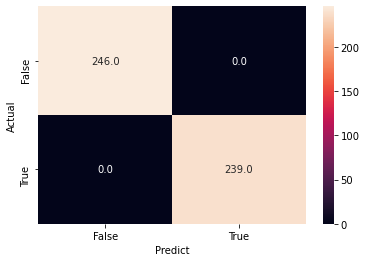

In [116]:
# Vizualizando a Matrix de confusão com o heatmap
sn.heatmap(confusion_matrix, annot = True, fmt=".1f")
plt.show()

In [135]:
# Predizendo as probabilidades 
yhat = model.predict_proba(X_test)

# Mantendo somente a classe positiva

yhat = yhat[:, 1]

In [137]:
# Plot da AUC
def plot_roc_curve(y_true, y_score, figsize=(10,6)):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize = figsize)
    auc_value = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, color = 'orange', label = 'ROC curve (area = %0.9f)' % auc_value)
    plt.plot([0, 1], [0, 1], color = 'darkblue', linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

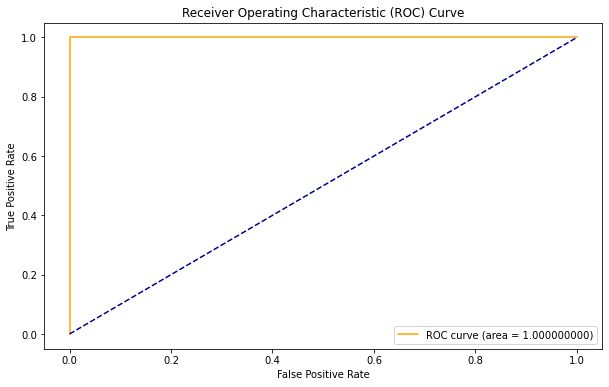

In [138]:
plot_roc_curve(y_test, yhat)

In [120]:
X_test

,QT_TOTAL_HIT_PAYWALL,DIASNAVEGADOS,NOTICIASLIDAS,VISITAS_CAPA,USOU_APP,PES_GENERO,ATR_PF_GEO_RENDA_FAM,IDADE
1078,0,0,0,0,False,False,4,42.0
1431,0,0,0,0,False,False,3,45.0
1485,0,0,0,0,False,False,3,26.0
674,0,4,5,0,False,True,3,31.0
1425,6,51,177,0,False,False,4,36.0
...,...,...,...,...,...,...,...,...
597,0,4,5,0,False,True,2,50.0
1729,3,2,5,0,False,False,4,78.0
393,0,5,2,0,False,False,4,37.0
1059,46,33,30,75,False,False,5,33.0


In [121]:
0,16,5,84,0,0,5,39.0

(0, 16, 5, 84, 0, 0, 5, 39.0)